<a href="https://colab.research.google.com/github/ashlinrodrig/532_final-project/blob/main/LSTM_532.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Train Loss: 0.0758, Val Loss: 0.0759
Epoch 2, Train Loss: 0.0753, Val Loss: 0.0759
Epoch 3, Train Loss: 0.0752, Val Loss: 0.0759
Epoch 4, Train Loss: 0.0751, Val Loss: 0.0762
Epoch 5, Train Loss: 0.0750, Val Loss: 0.0759
Epoch 6, Train Loss: 0.0749, Val Loss: 0.0760
Epoch 7, Train Loss: 0.0749, Val Loss: 0.0761
Epoch 8, Train Loss: 0.0749, Val Loss: 0.0761
Epoch 9, Train Loss: 0.0749, Val Loss: 0.0764
Epoch 10, Train Loss: 0.0748, Val Loss: 0.0758


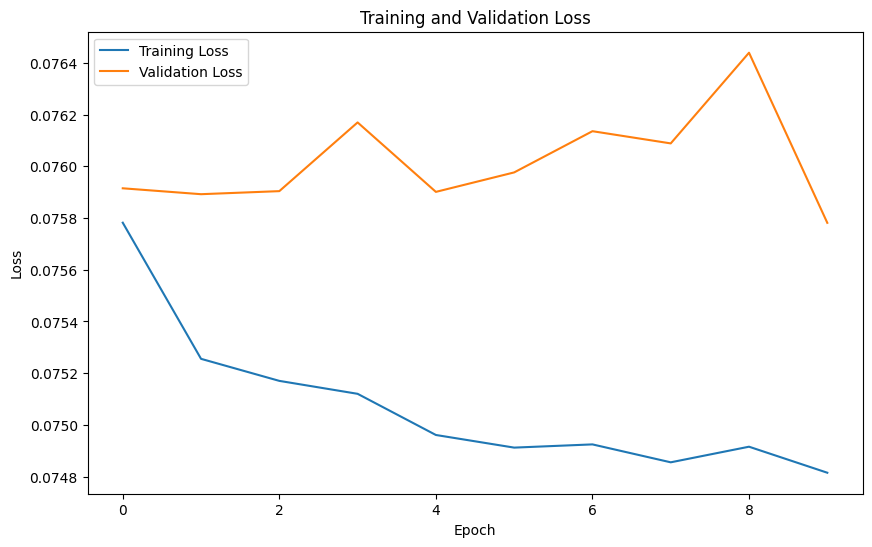

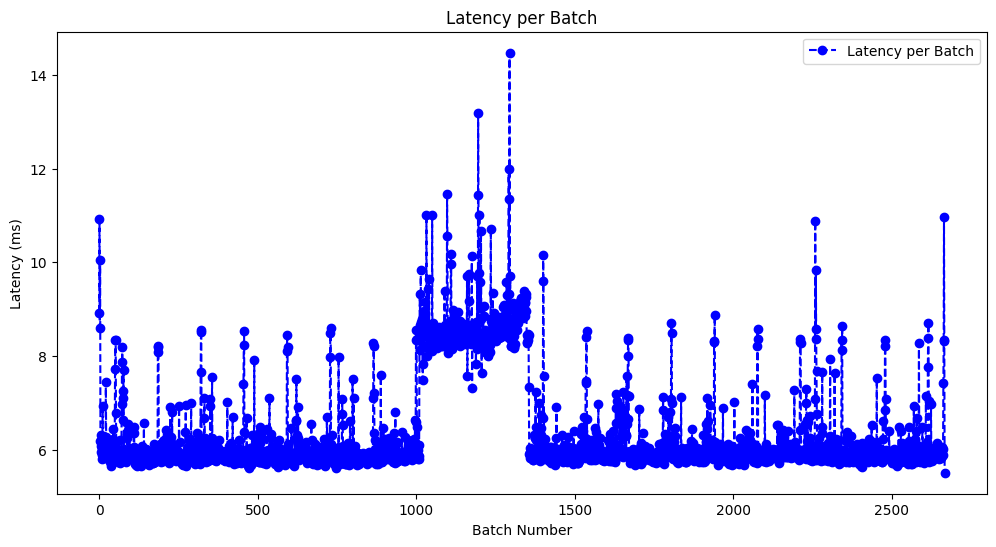

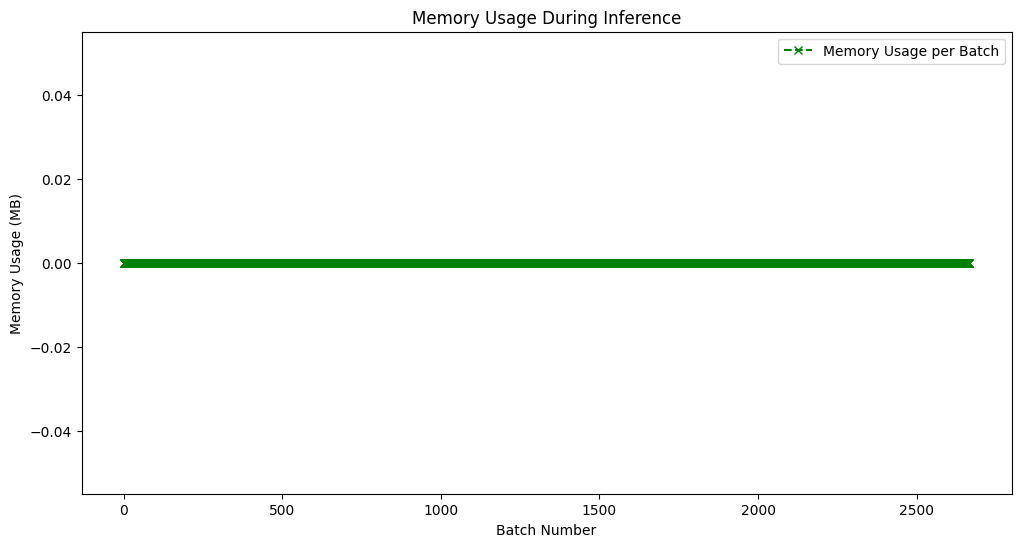

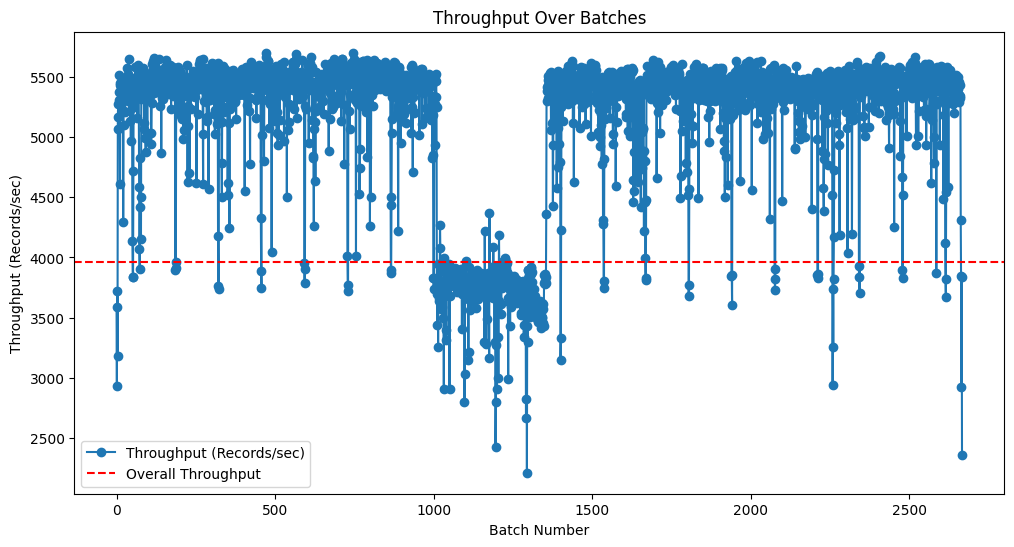

Throughput (Records/sec): 3963.6704
Accuracy: 0.9855


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import psutil
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
data = pd.read_csv(
    'f1dataset.csv',  # Replace with the correct file path
    na_values=['?', 'NA', 'null', ''],  # Handle missing values
    low_memory=False
)

# Fill missing values and handle numeric and categorical columns
data.fillna(0, inplace=True)
numerical_columns = ['milliseconds_x', 'milliseconds_y', 'lap', 'stop', 'points', 'positionOrder', 'cumulative_time']
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce', axis=1)

# Encode categorical and target columns
data['positionText'] = data['positionText'].astype(str)  # Example string column
data['is_pit_stop'] = data['is_pit_stop'].astype(int)  # Binary target column

# Create features for LSTM
feature_columns = ['lap', 'milliseconds_x', 'milliseconds_y', 'stop', 'points', 'positionOrder', 'cumulative_time']
data_features = data[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Encode the full_name column
def char_to_int(strings):
    all_chars = set("".join(strings))
    char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
    max_length = max(len(name) for name in strings)
    encoded_names = [[char_to_idx[char] for char in name] + [0] * (max_length - len(name)) for name in strings]
    return np.array(encoded_names), char_to_idx

encoded_names, _ = char_to_int(data['full_name'].astype(str))
name_features = pd.DataFrame(encoded_names, columns=[f'name_char_{i}' for i in range(encoded_names.shape[1])])
data_features = pd.concat([data_features, name_features], axis=1)

# Step 2: Create Sequences for LSTM
def create_sequences_with_names(data, names, targets, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        name = names[i+seq_length]
        combined_seq = np.hstack([seq, np.tile(name, (seq_length, 1))])
        sequences.append(combined_seq)
        labels.append(targets.iloc[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
sequences, labels = create_sequences_with_names(data_features, encoded_names, data['is_pit_stop'], seq_length)

# Step 3: Split Data into Training and Testing Sets
features_train, features_test, targets_train, targets_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Step 4: Define Dataset Class
class F1Dataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

train_loader = DataLoader(F1Dataset(features_train, targets_train), batch_size=32, shuffle=True)
test_loader = DataLoader(F1Dataset(features_test, targets_test), batch_size=32, shuffle=False)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return self.sigmoid(output)

# Initialize model, loss, and optimizer
input_size = sequences.shape[2]
model = LSTMModel(input_size, hidden_size=128, output_size=1, num_layers=2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Training Loop with Loss Tracking
train_losses, val_losses = [], []
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_y = batch_y.unsqueeze(1)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_y = batch_y.unsqueeze(1)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Step 7: Evaluate the Model
def evaluate_metrics_with_plots(model, test_loader):
    model.eval()
    all_targets, all_predictions = [], []
    latency_times, memory_usages, throughput_per_batch = [], [], []
    throughput_count = 0

    start_time = time.time()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_y = batch_y.unsqueeze(1)
            process = psutil.Process()
            memory_before = process.memory_info().rss / (1024 ** 2)

            batch_start_time = time.time()
            outputs = model(batch_x)
            batch_latency = time.time() - batch_start_time

            memory_after = process.memory_info().rss / (1024 ** 2)
            memory_usages.append(max(memory_after - memory_before, 0))

            predictions = (outputs > 0.5).float()
            all_targets.extend(batch_y.tolist())
            all_predictions.extend(predictions.squeeze().tolist())
            latency_times.append(batch_latency)
            throughput_count += len(batch_x)
            throughput_per_batch.append(len(batch_x) / batch_latency)

    end_time = time.time()
    total_time = end_time - start_time
    throughput = throughput_count / total_time
    overall_throughput = len(all_targets) / total_time
    accuracy = accuracy_score(all_targets, all_predictions)

    metrics = {
        'Latency (ms)': [latency * 1000 for latency in latency_times],
        'Memory Usage (MB)': memory_usages,
        'Throughput (Records/sec)': throughput,
        'Accuracy': accuracy,
    }

    plt.figure(figsize=(12, 6))
    plt.plot(metrics['Latency (ms)'], label="Latency per Batch", marker="o", linestyle="--", color="blue")
    plt.xlabel("Batch Number")
    plt.ylabel("Latency (ms)")
    plt.title("Latency per Batch")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(metrics['Memory Usage (MB)'], label="Memory Usage per Batch", marker="x", linestyle="--", color="green")
    plt.xlabel("Batch Number")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage During Inference")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(throughput_per_batch, label='Throughput (Records/sec)', marker='o')
    plt.axhline(overall_throughput, color='r', linestyle='--', label='Overall Throughput')
    plt.xlabel('Batch Number')
    plt.ylabel('Throughput (Records/sec)')
    plt.title('Throughput Over Batches')
    plt.legend()
    plt.show()

    print(f"Throughput (Records/sec): {metrics['Throughput (Records/sec)']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")

    return metrics

# Evaluate the model and plot metrics
metrics = evaluate_metrics_with_plots(model, test_loader)
